In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json, torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl

import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix
from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from sklearn.metrics import precision_recall_fscore_support

from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
train_path = "/home/andrew/go_metric/data/go_bench"

train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
test_dataset = BertSeqDataset.from_pickle(f"{train_path}/test.pkl")

collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=False)
val_dataloader_params = {"shuffle": False, "batch_size": 256, "collate_fn":collate_seqs}
train_loader = DataLoader(train_dataset, **val_dataloader_params, num_workers=6)
val_loader = DataLoader(val_dataset, **val_dataloader_params, num_workers=6)
test_loader = DataLoader(test_dataset, **val_dataloader_params, num_workers=6)

In [3]:
from Bio import SeqIO
import re
import torch.utils.data as data
import numpy as np
import json, torch

device = torch.device('cuda:1')

In [8]:
from transformers import BertModel, BertTokenizer
import re
model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
model.to(device)
model.eval()
print("Rostlab Model Loaded")

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Rostlab Model Loaded


In [12]:
bert_tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
def seq_collator(batch):
    ids, sequences = [x['prot_id'] for x in batch], [x['seq'] for x in batch]
    inputs = bert_tokenizer.batch_encode_plus(sequences,
                                                add_special_tokens=True,
                                                padding='longest',
                                                max_length=2400,
                                                truncation=True,
                                                return_attention_mask=True)
    return ids, inputs

def get_rostlab_embeddings(model, dataset, device):
    dataloader = DataLoader(dataset, collate_fn=seq_collator, batch_size=8, shuffle=False)
    prot_ids, emb_l = [], []
    with torch.no_grad():
        for ids, inputs in dataloader:
            prot_ids.extend(ids)
            tokenized_sequences = torch.tensor(inputs["input_ids"]).to(device)
            attention_mask = torch.tensor(inputs["attention_mask"]).to(device)
            embeddings = model(
                input_ids=tokenized_sequences, attention_mask=attention_mask
            )
            seq_lens = torch.sum(attention_mask, dim=1, keepdim=True) - 1
            B, L = attention_mask.shape
            embeddings = embeddings[0]
            embeddings = embeddings[:, 1:] * attention_mask[:, 1:].view(B, L-1, 1)
            embedding = embeddings.sum(dim=1) / seq_lens
            emb_l.append(embedding)
            if(len(prot_ids) % 512 == 0):
                print(f"{len(prot_ids)*100 / len(dataset)}%")
    embeddings = torch.cat(emb_l, dim=0).cpu()
    return prot_ids, embeddings
            # for seq_num, seq_len in enumerate(seq_lens):
            #     # slice off first and last positions (special tokens)
            #     embedding = embeddings[seq_num][1 : seq_len + 1].mean(axis=0)
            #     emb_l.append(embedding)    

train_ids, train_embeddings = get_rostlab_embeddings(model, train_dataset, device)
val_ids, val_embeddings = get_rostlab_embeddings(model, val_dataset, device)
test_ids, test_embeddings = get_rostlab_embeddings(model, test_dataset, device)


0.6592416146269233%


In [ ]:
import pickle
emb_dict = {"prot_id": train_ids, "embedding": train_embeddings}
with open("eval/rostlab_train_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)
    
emb_dict = {"prot_id": val_ids, "embedding": val_embeddings}
with open("eval/rostlab_train_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)

emb_dict = {"prot_id": test_ids, "embedding": test_embeddings}
with open("eval/rostlab_train_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)

In [5]:
import pickle
with open("emb/rostlab_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_embeddings = emb_dict['prot_id'], emb_dict['embedding']

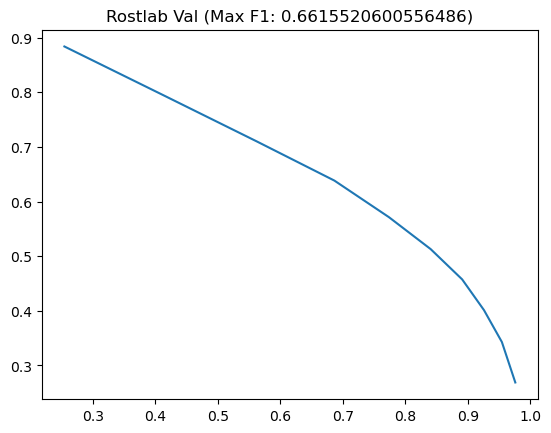

In [10]:
from go_metric.multilabel_knn import embedding_knn
train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()
rostlab_preds = embedding_knn(train_embeddings, val_embeddings, train_labels, k=10)


from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support
def threshold_stats(testing_matrix, prediction_matrix):
    precs = []
    recs = []
    f_scores = []
    rms = []
    for threshold in np.linspace(0.001, 1, 100):
        preds = prediction_matrix.copy()
        preds.data = np.where(preds.data >= threshold, 1, 0)
        preds.eliminate_zeros()
        p, r, f, support = precision_recall_fscore_support(testing_matrix, preds, average='micro')
        precs.append(p)
        recs.append(r)
        f_scores.append(f)
        rms.append(r*r * preds.shape[0] * preds.shape[1] / preds.sum())
    return precs, recs, f_scores, rms

precs, recs, f_scores, rms = threshold_stats(csr_matrix(val_labels), csr_matrix(rostlab_preds))
plt.plot(precs, recs)
plt.title(f"Rostlab Val (Max F1: {max(f_scores)})")
plt.show()


In [7]:
import pickle
with open("emb/finetune_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, finetune_train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/finetune_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, finetune_val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/finetune_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, finetune_test_embeddings = emb_dict['prot_id'], emb_dict['embedding']

In [6]:
from go_metric.models.bert_emb import ProtBertBFDClassifier
import pickle 
with open("checkpoints/bert_emb_hparams.pkl", "rb") as f:
    hparams = pickle.load(f)
    hparams.num_classes = 865
model = ProtBertBFDClassifier.load_from_checkpoint("checkpoints/bert_emb.ckpt", hparams=hparams)
model.eval()
device = torch.device('cuda:1')
model.to(device)

Lightning automatically upgraded your loaded checkpoint from v1.7.3 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints/bert_emb.ckpt`
Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly ide


-- Encoder model fine-tuning


ProtBertBFDClassifier(
  (ProtBertBFD): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-

In [9]:
def get_finetune_embeddings(model, dataset, device):
    collate_seqs = get_bert_seq_collator(max_length=1024, add_special_tokens=True)
    dataloader = DataLoader(dataset, collate_fn=collate_seqs, batch_size=32, shuffle=False)
    prot_ids, emb_l = [], []
    with torch.no_grad():
        for inputs in dataloader:
            prot_ids.extend(inputs['prot_id'])
            tokenized_sequences = inputs["seq"].to(device)
            attention_mask = inputs["mask"].to(device)

            word_embeddings = model.ProtBertBFD(tokenized_sequences,
                                           attention_mask)[0]
            embedding = model.pool_strategy({"token_embeddings": word_embeddings,
                                      "cls_token_embeddings": word_embeddings[:, 0],
                                      "attention_mask": attention_mask,
                                      }, pool_max=False, pool_mean_sqrt=False)
            emb_l.append(embedding.cpu())
            if(len(prot_ids) % 512 == 0):
                print(f"{len(prot_ids)*100 / len(dataset)}%")
    embeddings = torch.cat(emb_l, dim=0)
    return prot_ids, embeddings

train_ids, train_embeddings = get_finetune_embeddings(model, train_dataset, device)
emb_dict = {"prot_id": train_ids, "embedding": train_embeddings}
with open("eval/finetune_train_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)
val_ids, val_embeddings = get_finetune_embeddings(model, val_dataset, device)
emb_dict = {"prot_id": val_ids, "embedding": val_embeddings}
with open("eval/finetune_train_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)
test_ids, test_embeddings = get_finetune_embeddings(model, test_dataset, device)
emb_dict = {"prot_id": test_ids, "embedding": test_embeddings}
with open("eval/finetune_train_emb.pkl", "wb") as f:
    pickle.dump(emb_dict, f)


0.6592416146269233%
1.3184832292538466%
1.97772484388077%
